In [1]:
'''
Look into outputs. 

Phonemes labels are at the end of each line. 

Get average length of phoneme. 

Get the mean feature, the average, everything from post two weeks. 

Change kevin's code in your directory to write outputs to output dir.

Find out which files were affected in Kevin's dataset. Replace them.
'''
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import umap
import json
import pickle

In [2]:
ALL_PHONEMES = ['iy',  'ux',  'eh',  'ix',  'ao',  'aa',  'ax-h',  'ih',  'uh',  'ah',  'uw',  'ax',  'ae',  'ay',  'aw',   'ey',  'ow',  'oy',  'y',  'er',  'l','el','axr','w','r','t','p','d','jh','b','g','ch','k','v','dh','th','hv','s','zh','f','z','hh','sh','nx','m','en','em','n','eng','ng','pau','bcl','pcl','tcl','epi','q','dcl','h','dx','gcl','kcl','h#']

In [3]:
len(ALL_PHONEMES)

62

In [4]:
TEST_FILE = 'Y:/personal/ojuba.mezisashe/Sentences/TIMIT_dp/output/TRAIN/DR1/FCJF0/SI648.txt'

In [5]:
vowels_and_consonants_map = {"vowels":{"iy","ih", 'eh', 'ae', 'aa', 'ah', 'ao', 'uh', 'uw', 'ux', 'ax', 'ax-h', 'ix', 'ey', 'aw', 'ay', 'oy', 'ow'},
                             "semi-vowels": {'l', 'el', 'r', 'w', 'y', 'er', 'axr'},
                             "consonants": {'b', 'd', 'g', 'p', 't', 'k', 'jh', 'ch', 's', 'sh', 'z', 'zh', 'f', 'th', 'v', 'dh', 'hh', 'hv', 'm', 'em', 'n', 'nx', 'ng', 'eng', 'en', 'dx', 'bcl', 'dcl', 'gcl', 'pcl', 'tcl', 'kcl', 'h', 'pau', 'epi', 'q'},
                             "h#": {"h#"}}

In [6]:
manner_of_articulation_map = {"vowels":{"iy","ih", 'eh', 'ae', 'aa', 'ah', 'ao', 'uh', 'uw', 'ux', 'ax', 'ax-h', 'ix'},
                             "dipthongs":{'ey', 'aw', 'ay', 'oy', 'ow'},
                             "semi-vowels": {'l', 'el', 'r', 'w', 'y', 'er', 'axr'},
                             "stops": {'b', 'd', 'g', 'p', 't', 'k', 'jh', 'ch'},
                             "fricatives": {'s', 'sh', 'z', 'zh', 'f', 'th', 'v', 'dh', 'hh', 'hv'},
                             "nasals": {'m', 'em', 'n', 'nx', 'ng', 'eng', 'en'},
                             "silence": {'dx', 'bcl', 'dcl', 'gcl', 'pcl', 'tcl', 'kcl', 'h', 'pau', 'epi', 'q'},
                             "h#": {"h#"}}

# Get files to process

In [5]:
# check if file has been opened
def is_timit_txt_file_processed(filename): # checks if file is shorter than 1000 kb
    return os.path.getsize(filename) > 1000

def is_timit_txt_file_processe2(filename): # slower because it opens files and checks if it is only one line (the sentence spoken as obseved in timit dataset) or multiple. use as confirmation
    f = open(filename, "r")
    lines = f.readlines()
    return not len(lines)==1

In [75]:
'''
get list of all files. write to saved variable file
'''

# # get list of all files
# files_searching = [] # list of all files that will be used in getting weighted average
# directory_train_or_dev = "Y:/personal/ojuba.mezisashe/Sentences/TIMIT_dp/output/TRAIN" # should be of depth = (dev, test, or train) in timit dataset
# for current_directory,subfolders,files in list(os.walk(directory_train_or_dev))[2:]:
#     for file in files:
#         file = current_directory + "\\" + file
#         if file.lower().endswith(".txt"):
#             files_searching.append(file)
            
# with open("saved_variables/files_searching.txt", "a+") as f:
#     for file in files_searching:
#         f.write(str(file)+"\n")

In [29]:
f = open('saved_variables/files_searching.txt', "r")
files_searching = [x.strip() for x in f.readlines()]
f.close()

In [30]:
files_searching

['Y:/personal/ojuba.mezisashe/Sentences/TIMIT_dp/output/TRAIN\\DR1\\FCJF0\\SI1027.txt',
 'Y:/personal/ojuba.mezisashe/Sentences/TIMIT_dp/output/TRAIN\\DR1\\FCJF0\\SI1657.txt',
 'Y:/personal/ojuba.mezisashe/Sentences/TIMIT_dp/output/TRAIN\\DR1\\FCJF0\\SI648.txt',
 'Y:/personal/ojuba.mezisashe/Sentences/TIMIT_dp/output/TRAIN\\DR1\\FCJF0\\SX127.txt',
 'Y:/personal/ojuba.mezisashe/Sentences/TIMIT_dp/output/TRAIN\\DR1\\FCJF0\\SX217.txt',
 'Y:/personal/ojuba.mezisashe/Sentences/TIMIT_dp/output/TRAIN\\DR1\\FCJF0\\SX307.txt',
 'Y:/personal/ojuba.mezisashe/Sentences/TIMIT_dp/output/TRAIN\\DR1\\FCJF0\\SX37.txt',
 'Y:/personal/ojuba.mezisashe/Sentences/TIMIT_dp/output/TRAIN\\DR1\\FCJF0\\SX397.txt',
 'Y:/personal/ojuba.mezisashe/Sentences/TIMIT_dp/output/TRAIN\\DR1\\FDAW0\\SI1271.txt',
 'Y:/personal/ojuba.mezisashe/Sentences/TIMIT_dp/output/TRAIN\\DR1\\FDAW0\\SI1406.txt',
 'Y:/personal/ojuba.mezisashe/Sentences/TIMIT_dp/output/TRAIN\\DR1\\FDAW0\\SI2036.txt',
 'Y:/personal/ojuba.mezisashe/Sentences

# UMAP visualization

In [24]:
def get_phonemes_from_single_file(filename):
    '''
    this returns a dicitonary mapping phoneme names to numpy 1-D matrices of features of the phoneme class of a particular length (padded with nans if data is less than) found in a file
    inputs:
        filename (str): the input file
        
    '''
    output_dictionary = {}
    f = open(filename, "r")
    lines = f.readlines()
    
    f.close()
    for line in lines: 
        line = line.split()
        current_phoneme = line[-1]
        line = line[:-1]
        line = np.array(line,dtype="float64")
        if current_phoneme in output_dictionary:
            output_dictionary[current_phoneme].append(line)
        else:
            output_dictionary[current_phoneme] = [line]
        
    return output_dictionary

In [25]:
# testing above function
print(TEST_FILE)
_ = get_phonemes_from_single_file(TEST_FILE)
# _ = get_phonemes_from_single_file(filename, 100) # edge case test

Y:/personal/ojuba.mezisashe/Sentences/TIMIT_dp/output/TRAIN/DR1/FCJF0/SI648.txt


In [28]:
# test
f = open(TEST_FILE, "r")
lines = f.readlines()
len_file = len(lines)
assert sum([len(y) for x,y in _.items()])==len_file

In [ ]:
'''
put umap plotting into function
'''

In [5]:
def get_features_from_files(files_searching, normalize=False, folder_with_mean_and_stds=None):
    '''
    folder_with_mean_and_stds (str): folder path containing files names (phoneme)_average.txt or (phoneme)_std.txt which can be loaded using np.loadtxt. Files should contain average and std phoneme values with features of length weighted_average_phoneme_length.
    '''
    
    
    if normalize:
        if folder_with_mean_and_stds:
            pass
        else:
            raise Exception("Must pass in folder_with_mean_and_stds as an argument if normalize is set to True")

    features = []
    phoneme_to_number = {}
    phonemes_from = [] # this will put the phonemes here which will be used to colour code the data

    current = 0 # used to sample how many files running through for testing
    _break = False
    for filename in files_searching:
        phonemes_features_dict = get_phonemes_from_single_file(filename)
        for phoneme in phonemes_features_dict:
            features_for_phoneme = phonemes_features_dict[phoneme]
            if normalize: # if looking for normalized features, normalized using the saved mean and std
                phoneme_mean = np.loadtxt(folder_with_mean_and_stds+"/"+phoneme+"_average.txt", dtype="float64")
                phoneme_std = np.loadtxt(folder_with_mean_and_stds+"/"+phoneme+"_std.txt", dtype="float64")
                features_for_phoneme,_,__ = zmuv_normalize_phoneme_class(features_for_phoneme, True, phoneme_mean, phoneme_std)
            
            features.extend(features_for_phoneme)
            if phoneme in phoneme_to_number:
                pass
            else:
                phoneme_to_number[phoneme] = len(phoneme_to_number)+1
            phonemes_from.extend([phoneme_to_number[phoneme]]*len(features_for_phoneme))

        current += 1
        print(current)
        if current == 10:
            break

    return features,phonemes_from,phoneme_to_number

In [6]:
def plot_umap(features_rolled_out, phonemes_from, colour_map=None, colour_map_name=None):
    
    '''
    colour_map (dict): maps label of phoneme classification groups to a set/list of phonemes in that group. for example, the manner of articulation colour_map (from https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4100697) would be {"vowels":{"iy","ih", 'eh', 'ae', 'aa', 'ah', 'ao', 'uh', 'uw', 'ux', 'ax', 'ax-h', 'ix'},                             "dipthongs":{'ey', 'aw', 'ay', 'oy', 'ow'},"semi-vowels": {'l', 'el', 'r', 'w', 'y', 'er', 'axr'},"stops": {'b', 'd', 'g', 'p', 't', 'k', 'jh', 'ch'},"fricatives": {'s', 'sh', 'z', 'zh', 'f', 'th', 'v', 'dh', 'hh', 'hv'},"nasals": {'m', 'em', 'n', 'nx', 'ng', 'eng', 'en'},"silence": {'dx', 'bcl', 'dcl', 'gcl', 'pcl', 'tcl', 'kcl', 'h', 'pau', 'epi', 'q'},"h#": {"h#"}} 
    '''
    
    features_rolled_out = np.array(features_rolled_out, dtype=float)
    features_rolled_out = np.nan_to_num(features_rolled_out, copy=True, posinf=0, neginf=0)
    
    # copy pasted most of this code from mnist example
    reducer = umap.UMAP(random_state=42)
    embedding = reducer.fit_transform(features_rolled_out)

    # if issues, may be due to nan values. think how to deal with sparse data? maybe cut off at some point.
    fig, ax = plt.subplots(figsize=(12, 10))
    colors = phonemes_from
    if len(colors) < 5000:
        s = 10
    elif len(colors) < 100000:
        s=3
    else:
        s =1
    
    if colour_map:
        number_to_phoneme = {}

        for y,x in phoneme_to_number.items():
            number_to_phoneme[x]=y
        phonemes_from_colour_coded = []
        for phoneme_num in phonemes_from:
            phoneme = number_to_phoneme[phoneme_num]
            added = False
            for indx in range(len(colour_map)):
                if phoneme in list(colour_map.items())[indx][1]:
                    phonemes_from_colour_coded.append(indx)
                    added = True
                    break
            if added:
                continue
            else:
                phonemes_from_colour_coded.append(len(colour_map)+1)
                print(phoneme)
        colors = phonemes_from_colour_coded

    plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, cmap="Spectral", s=s)
    plt.setp(ax, xticks=[], yticks=[])
    plt.title("Phonemes", fontsize=18)

    if colour_map:
        try:
            plt.colorbar(boundaries=np.arange(len(set(colors)))-0.5).set_ticks(ticks=np.arange(len(set(colors))), labels=list(colour_map.keys())) #+["other"])
        except:
            m=plt.colorbar(boundaries=np.arange(len(set(colors)))-0.5)
            m.set_ticks(ticks=np.arange(len(set(colors)))) #+["other"])
            m.set_ticklabels(list(colour_map.keys()))
        if colour_map_name:
            plt.title("Phonemes according to "+ colour_map_name, fontsize=18)
    else:
        plt.colorbar().ax.tick_params(labelsize=10)


    plt.savefig(input("name matplotlib image: ")+".png")

In [100]:
# tests not normalized (both each phoneme and moa phoneme grouping visualized)
features_rolled_out, phonemes_from, phoneme_to_number = get_features_from_files(files_searching)

In [101]:
print(len(features_rolled_out)==len(phonemes_from))
print(len(features_rolled_out))

True
152933


C:\Users\sashe\anaconda3\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


name matplotlib image: g


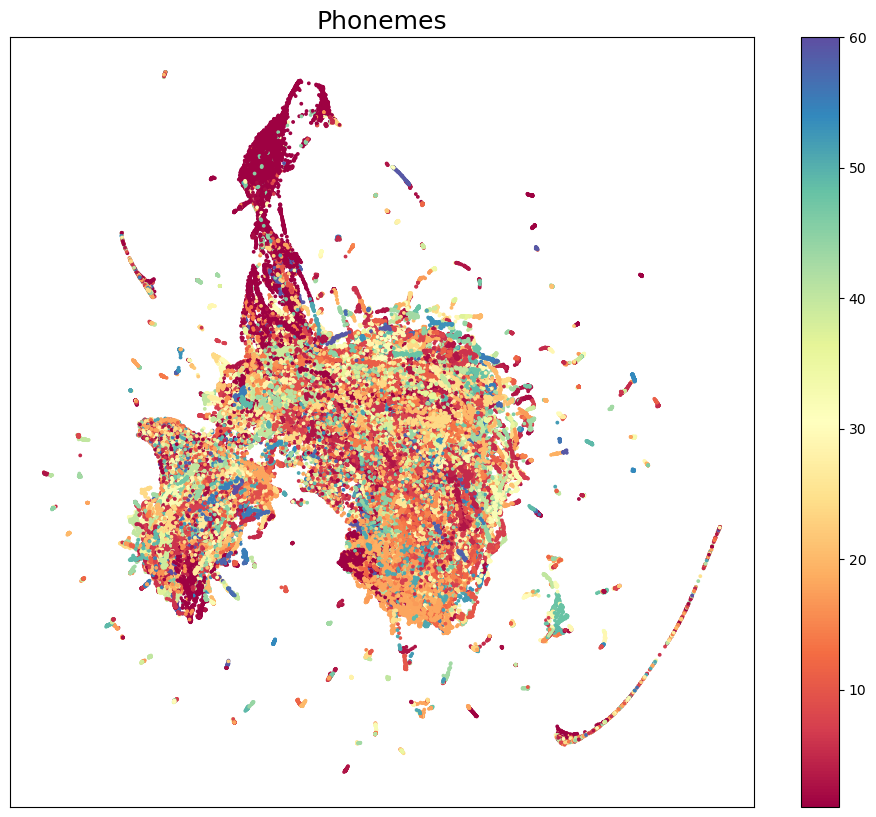

In [102]:
plot_umap(features_rolled_out, phonemes_from)

C:\Users\sashe\anaconda3\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


name matplotlib image: k


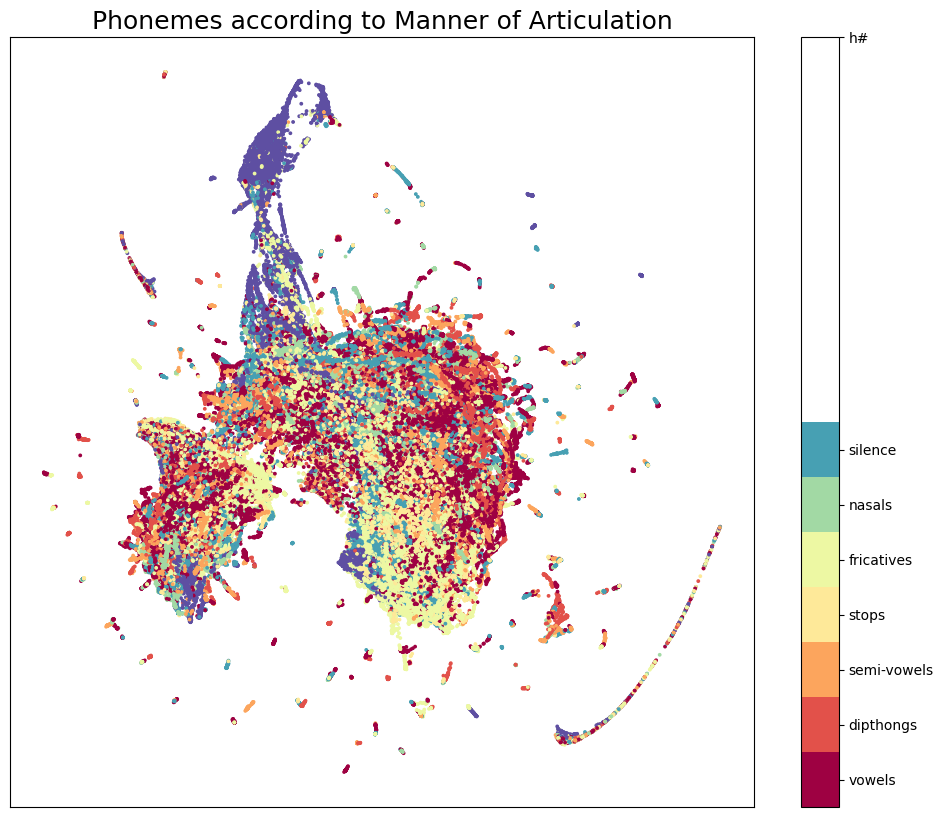

In [103]:
plot_umap(features_rolled_out, phonemes_from, manner_of_articulation_map, "Manner of Articulation")

C:\Users\sashe\anaconda3\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


name matplotlib image: u


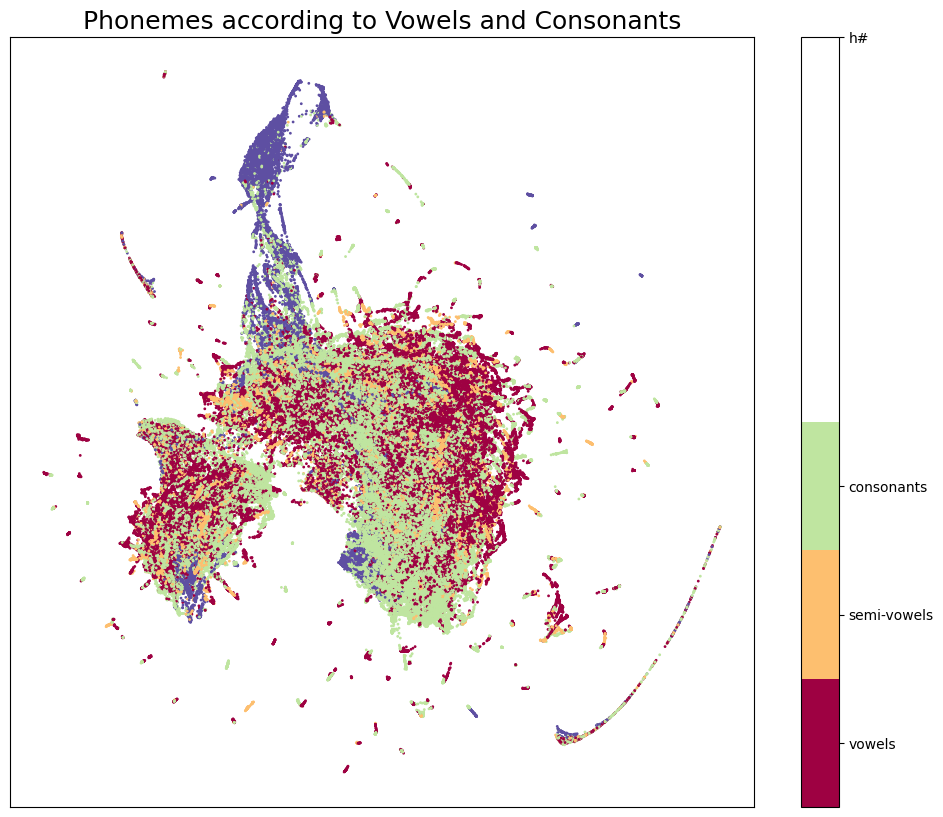

In [105]:
plot_umap(features_rolled_out, phonemes_from, vowels_and_consonants_map, "Vowels and Consonants")

In [19]:
features_rolled_out, phonemes_from,phoneme_to_number = get_features_from_files(files_searching, normalize=True, folder_with_mean_and_stds="saved_variables/average_and_std_phoneme_feature/")

1
2
3
4
5
6
7
8
9
10


In [ ]:
plot_umap(features_rolled_out, phonemes_from)

C:\Users\sashe\anaconda3\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


C:\Users\sashe\anaconda3\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


name matplotlib image: x


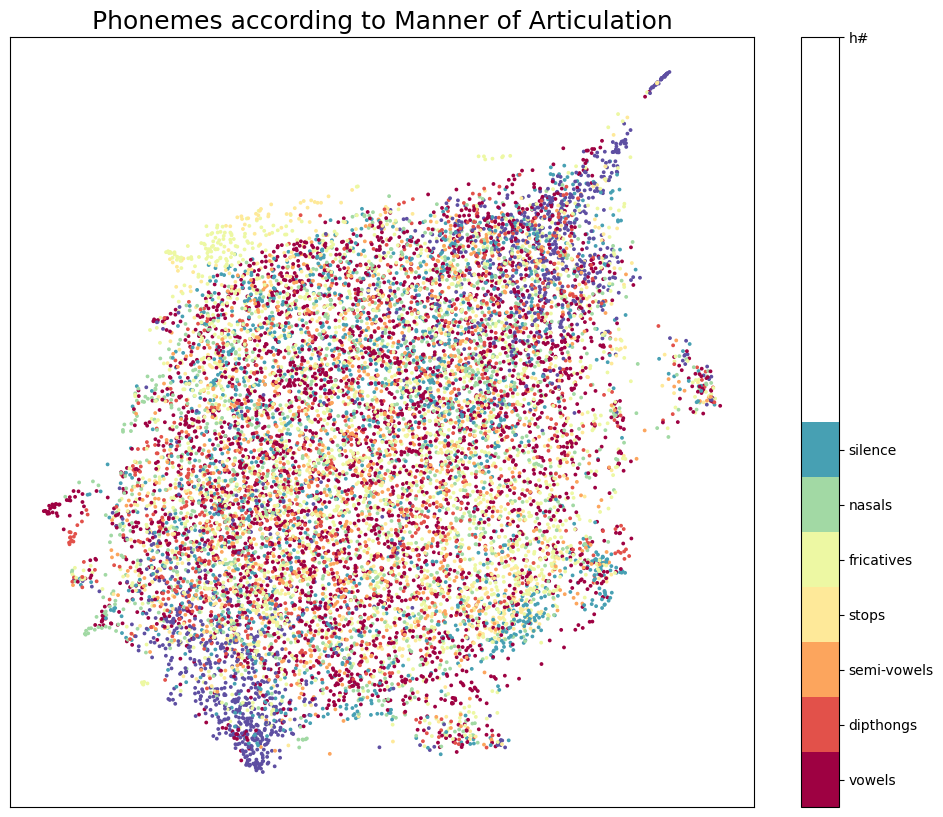

In [24]:
plot_umap(features_rolled_out, phonemes_from, manner_of_articulation_map, "Manner of Articulation")

C:\Users\sashe\anaconda3\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


name matplotlib image: c


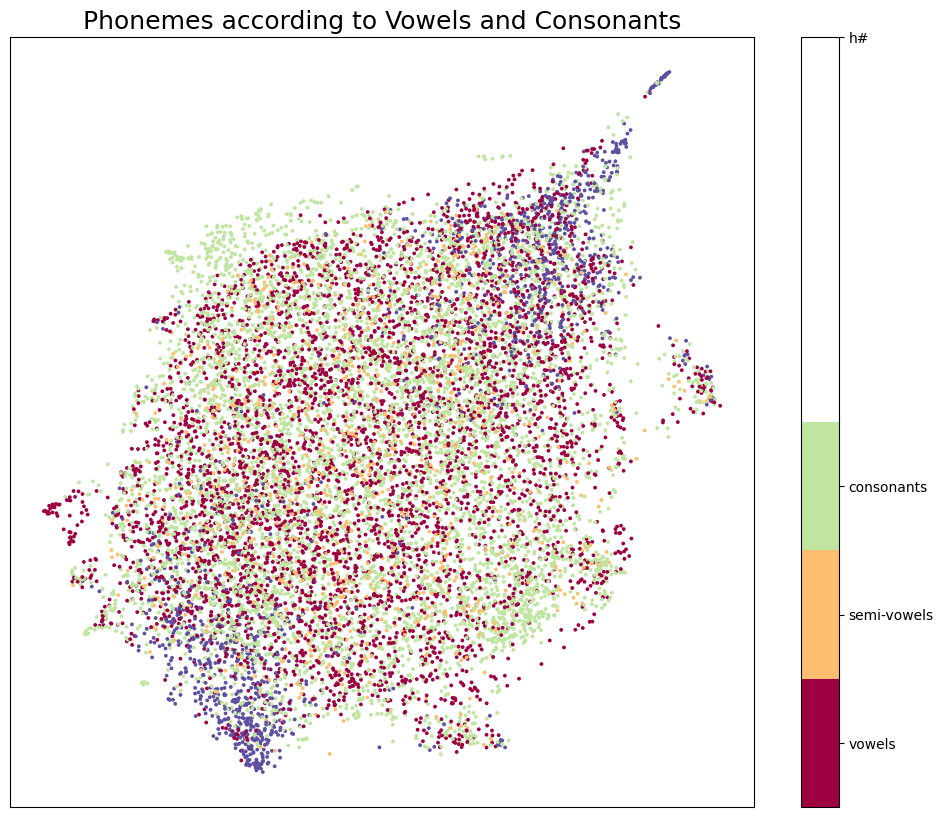

In [25]:
plot_umap(features_rolled_out, phonemes_from, vowels_and_consonants_map, "Vowels and Consonants")

# Zmuv normalization

In [57]:
# Get the mean feature, the average, everything from post two weeks. 
'''
look over data.
use matlab to understand how the data opens up


Get mean and standard deviation of each phoneme class.
	5. Perhaps visualize/plot the average phoneme for each phoneme class.
	6. For a phoneme, normalize by class: subtract from the mean and divide by standard deviation. And time align.
	7. Visualize the normalized features.
Look at the difference in pattern between normalized and un-normalized features.
'''

'\nlook over data.\nuse matlab to understand how the data opens up\n\n\nGet mean and standard deviation of each phoneme class.\n\t5. Perhaps visualize/plot the average phoneme for each phoneme class.\n\t6. For a phoneme, normalize by class: subtract from the mean and divide by standard deviation. And time align.\n\t7. Visualize the normalized features.\nLook at the difference in pattern between normalized and un-normalized features.\n'

## Test Zmuv normalization and visualization for one phoneme class

In [ ]:
'''
edit and test below. to take output from get_phonemes_from_single_file and get the phonemes needed.
'''

In [17]:
def get_instances_of_phoneme_from_single_file(input_filename_or_file_phoneme_features_dictionary, phoneme):  ## TODO: this is a misnomer and is confusing bc it can also get instances of phonemes from a dictionary and not only a file. RENAME!
    '''
    this returns a numpy matrix of features of a phoneme class
    inputs:
        input_filename_or_file_phoneme_features_dictionary (str or dict): the input file or a dictionary output from get_phonemes_from_single_file
        phoneme (str): the phoneme class (assuming working with timit database)
        
        returns:
        list of numpy array features of a phoneme class OR empty list if phoneme does not occur in file at all
    '''
    if type(input_filename_or_file_phoneme_features_dictionary)==str:
        phoneme_features_dict = get_phonemes_from_single_file(input_filename_or_file_phoneme_features_dictionary)
    else:
        phoneme_features_dict = input_filename_or_file_phoneme_features_dictionary
        
    if phoneme in phoneme_features_dict:
        return phoneme_features_dict[phoneme]
    else:
        return []

In [55]:
# testing function
_ = get_instances_of_phoneme_from_single_file(TEST_FILE, "aa")
# np.array(_, dtype="float64").shape

In [56]:
len(_)

60

In [59]:
_[0]

array([ -5.39162697,  -4.1992573 ,  -3.1264317 ,  -2.4412364 ,
        -0.43176142,  -0.21699331,  -1.76876966,  -1.99354707,
        -2.48614179,  -3.67402562,  -3.6102294 ,  -5.63349896,
        -3.32721695,  -2.67906897,  -1.02487802,  -1.23236014,
        -3.08488195,  -4.71350045,  -6.38421882,  -3.46597761,
        -3.08189009,  -6.36507014,  -7.91372418,  -5.13061136,
        -5.14148409,  -5.03679018,  -5.10492368,  -5.88965853,
        -6.24468823,  -5.5771941 ,  -7.11468474,  -4.11096436,
        -2.86796962,  -4.86834208,  -3.88084238,  -4.30612522,
        -3.47233312,  -3.51148202,  -4.32331476,  -2.99264739,
        -3.3601343 ,  -4.7228985 ,  -5.4897095 ,  -7.35813616,
        -7.80907148,  -5.83104707,  -3.52246311,  -3.30537786,
        -4.58954719,  -4.81050078,  -4.31253599,  -5.2048227 ,
        -8.07538286,  -7.19697528,  -7.20483338,  -6.86035114,
        -7.42281858,  -9.69947281,  -6.7699896 ,  -8.21677471,
        -5.55130226,  -4.92272272,  -6.61478914, -11.37

In [62]:
np.mean(_,0).shape

(130,)

In [119]:
phoneme = "aa"
average_phoneme_class_length = int(average_phoneme_lengths[phoneme])
feature_matrix = []

for file in files_searching:
    feature_matrix.extend(get_instances_of_phoneme_from_single_file(file, phoneme, average_phoneme_class_length))
feature_matrix = np.array(feature_matrix, dtype="float64")

In [63]:
def zmuv_normalize_phoneme_class(feature_matrix, calculate_mean_and_std=True, phoneme_mean=None, phoneme_std=None):
    '''
    return the normalized feature class of matrix phoneme_class_features_matrix, the mean and standard deviations
    inputs:
        feature_matrix (np.array): a 2d feature matrix of various instances of a phoneme. The phonemes instances are stacked on the z (?) axis
        calculate_mean_and_std (bool): whether to calculate mean and std or not. should be false if inputting values for phoneme_mean and phoneme_std
        phoneme_mean (np.array):  the average feature
        phoneme_std (np.array):  the standard deviation of features
        
    returns:
        normalized_features (np.array): the normalized feature matrix 
        phoneme_mean (np.array):  the average feature
        phoneme_std (np.array):  the standard deviation of features
    '''
    if calculate_mean_and_std:
        phoneme_mean, phoneme_std = np.mean(feature_matrix,0),np.std(feature_matrix,0)
    normalized_features = (feature_matrix - phoneme_mean)/(phoneme_std)
    
    return normalized_features, phoneme_mean, phoneme_std

In [67]:
feature_matrix_normed, phoneme_mean, phoneme_std = zmuv_normalize_phoneme_class(_)

In [77]:
# TODO: EDIT THIS TO MAKE MORE EFFICIENT TO RUN ON WHOLE DATASET
# get averages and stds using the weighted total average length
output_folder = "saved_variables/average_and_std_phoneme_feature/" ### CHANGE THIS
phonemes_to_features = {}
count = 0
for file in files_searching:
    phonemes_from_file = get_phonemes_from_single_file(file)
    for phoneme in phonemes_from_file:
        if phoneme in phonemes_to_features:
            pass
        else:
            phonemes_to_features[phoneme]=[]
        phonemes_to_features[phoneme].extend(get_instances_of_phoneme_from_single_file(phonemes_from_file, phoneme))
    count += 1
    if count == 5:
        break
        
for phoneme in phonemes_to_features:
    feature_matrix = np.array(phonemes_to_features[phoneme], dtype="float64")
    feature_matrix_normed, phoneme_mean, phoneme_std = zmuv_normalize_phoneme_class(feature_matrix, True)
    np.savetxt(output_folder+phoneme+"_average.txt", phoneme_mean)
    np.savetxt(output_folder+phoneme+"_std.txt", phoneme_std)

In [78]:
_ = np.loadtxt("test/iy_average.txt", dtype="float64")
_.shape

(130,)

In [ ]:
with open("../saved_variables/features_from_files.pkl", "rb") as f:  # Python 3: open(..., 'rb')
    features_rolled_out, phonemes_from, phoneme_to_number = pickle.load(f)


# plotting all classes
plot_umap(features_rolled_out, phonemes_from, weighted_average_phoneme_length) 


In [ ]:

# plotting with colour code by class
print("moa")
map_using = manner_of_articulation_map ### CHANGE
name_of_plot = "Manner of Articulation" ### CHANGE
plot_umap(features_rolled_out, phonemes_from, weighted_average_phoneme_length, map_using, name_of_plot)

# plotting with colour code by class
print("vowels and consonants")
map_using = vowels_and_consonants_map ### CHANGE
name_of_plot = "Vowels and Consonants" ### CHANGE
plot_umap(features_rolled_out, phonemes_from, weighted_average_phoneme_length, map_using, name_of_plot)


# plotting normalized 
# have to run get averages_and_std_per_phoneme.py first to save files to folder_with_mean_and_stds
print("normalized")

# plotting all classes
with open("../saved_variables/features_from_files_normalized.pkl", "rb") as f:  # Python 3: open(..., 'rb')
    features_rolled_out, phonemes_from, phoneme_to_number = pickle.load(f)
plot_umap(features_rolled_out, phonemes_from, weighted_average_phoneme_length) 

# plotting with colour code by class
print("moa")
map_using = manner_of_articulation_map ### CHANGE
name_of_plot = "Manner of Articulation" ### CHANGE
plot_umap(features_rolled_out, phonemes_from, weighted_average_phoneme_length, map_using, name_of_plot)

# plotting with colour code by class
print("vowels and consonants")
map_using = vowels_and_consonants_map ### CHANGE
name_of_plot = "Vowels and Consonants" ### CHANGE
plot_umap(features_rolled_out, phonemes_from, weighted_average_phoneme_length, map_using, name_of_plot)

# Normalize features in file and save to other file

In [91]:
def normalize_features_to_file(input_file, output_file, folder_with_mean_and_stds):
    if folder_with_mean_and_stds[-1] in ("/", "\\"):
        pass
    else:
        folder_with_mean_and_stds = folder_with_mean_and_stds + "/"
    output_features = []
    output_phonemes = []
    f = open(input_file, "r")
    lines = f.readlines()
    f.close()
    
    current_phoneme = "h#"
    previous_phoneme = ""
    
    features_of_phoneme = []
    for line in lines:
        line = line.split()
        current_phoneme = line[-1]
        if current_phoneme == "sil":
            current_phoneme = "h#"
        line = line[:-1]
        line = np.array(line,dtype="float64")
        
        if current_phoneme == previous_phoneme:
            pass
        elif previous_phoneme != "":
            phoneme_mean = np.loadtxt(folder_with_mean_and_stds+previous_phoneme+"_average.txt")
            phoneme_std = np.loadtxt(folder_with_mean_and_stds+previous_phoneme+"_std.txt")
            normalized,_,__ = zmuv_normalize_phoneme_class(features_of_phoneme, calculate_mean_and_std=False, phoneme_mean=phoneme_mean, phoneme_std=phoneme_std)
            output_features.extend(normalized)
            output_phonemes.extend([previous_phoneme]*normalized.shape[0])
            features_of_phoneme = []
        features_of_phoneme.append(line)
        previous_phoneme = current_phoneme
    phoneme_mean = np.loadtxt(folder_with_mean_and_stds+previous_phoneme+"_average.txt")
    phoneme_std = np.loadtxt(folder_with_mean_and_stds+previous_phoneme+"_std.txt")
    normalized,_,__ = zmuv_normalize_phoneme_class(features_of_phoneme, calculate_mean_and_std=False, phoneme_mean=phoneme_mean, phoneme_std=phoneme_std)
    output_features.extend(normalized)
    output_phonemes.extend([previous_phoneme]*normalized.shape[0])
    
    with open(output_file, "w+") as f:
        for indx in range(len(output_features)):
            line = output_features[indx]
            phoneme = output_phonemes[indx]
            f.write(" ".join(map(str, line)))
            f.write(" "+phoneme+"\n")

In [92]:
# normalize timit output
for file in files_searching:
    output_file = file.replace("TIMIT_dp", "TIMIT_normalized")
    normalize_features_to_file(file, output_file, "saved_variables/average_and_std_phoneme_feature")

KeyboardInterrupt: 

In [119]:
'''
# librispeech getting input files
old_folder = "Y:/personal/chu.kevin/TitanV/MaskEstimationPytorch/features/log_fft/fft_mask_dp_fft/train_librispeech_but_rev"
librispeech_training_files = []
for subfolder1 in os.listdir(old_folder):
    current_folder1 = old_folder+"/"+subfolder1
    if os.path.isdir(current_folder1):
        for subfolder2 in os.listdir(current_folder1):
            current_folder2 = current_folder1 + "/"+subfolder2
            if os.path.isdir(current_folder2):
                for filename in os.listdir(current_folder2):
                    if filename.lower().endswith(".txt"):
                        librispeech_training_files.append(current_folder2+"/"+filename)
with open("saved_variables/files_searching_librispeech_training.txt", "w+") as f:
    for file in librispeech_training_files:
        f.write(str(file)+"\n")'''